In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from google.cloud import bigquery

In [3]:
from dotenv import load_dotenv
load_dotenv("/Users/juanluis/Documents/credentials/env.txt")

True

In [4]:
#from utils_time_series import rolling_window_2d

In [5]:
def get_bq_client(creds_file, gcloud_project):
    return bigquery.Client.from_service_account_json(creds_file, project=gcloud_project)

In [6]:
#creds = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
project = "stock-sentiment-nlp"
dataset_id = "series"

In [7]:
stocks = ["AAPL", 'KHC', 'PEP', 'GS', 'MSFT', 'MCD', 'OXY']

In [8]:
bq_client = bigquery.Client()
sentiment = {}
for stock in stocks:
    full_table_id = f"{project}.{dataset_id}.{stock}_series"
    df = bq_client.query(f"select cast(index as date) as date, * except(index) from `{full_table_id}` order by index").result().to_dataframe()
    df.date = df.date.astype(np.datetime64)
    #df["index"] = df["index"].apply(lambda x : x.date())
    sentiment[stock] = df
    


In [9]:
import yfinance as yf

In [10]:
for stock in stocks:
    df = sentiment[stock]
    start = df.date.min()
    end = df.date.max()
    series = yf.download(stock, start= start, end= end)
    sentiment[stock] = pd.merge(df, series, left_on = "date", right_index=True, how = "left")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
import matplotlib.pyplot as plt

In [98]:
stock = sentiment["GS"]

In [99]:
# Conclusion. We want linera interpolation
import matplotlib.pyplot as plt
import seaborn as sns
gs = stock[["date", "Close"]]
gs.loc[:,"linear_inter"] = gs.Close.interpolate() - 1
gs.loc[:,"spline_inter"] = gs.Close.interpolate(method="spline", order=3) + 1
gs.loc[:,"from_derivatives_inter"] = gs.Close.interpolate(method="from_derivatives", order=2) + 2

/Users/juanluis/opt/anaconda3/envs/tfm/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='date'>

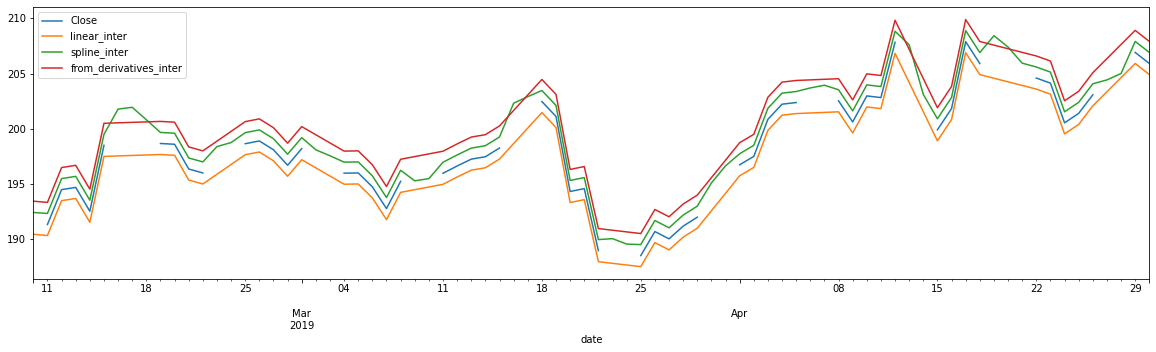

In [100]:
fig, ax = plt.subplots(figsize = (20,5))
series = gs.iloc[40:120]
series.plot(x = "date", ax = ax)
#pltsns.lineplot(data = series, )

In [281]:
df = stock.set_index("datinterpolateols = ['star1', 'star2', 'star3', 'star4', 'star5', 'Open', 'Close']
df= df[cols]

In [282]:
def fill_na_with_linear_space(prices):
    prices = prices.copy()
    if np.isnan(prices[0]):
        for value in prices[1:]:
            if np.isnan(value) == False:
                break
        prices[0] = value

    nan_count = 0
    new_prices = []
    for value in prices:
        if np.isnan(value):
            nan_count +=1
        else:
            if nan_count > 0:
                new = list(np.linspace(new_prices[-1],value,num = nan_count + 2).round(3))[1:]
                new_prices.extend(new)
                nan_count = 0
            else:
                new_prices.append(value)
    new_prices.extend([new_prices[-1]]*nan_count)
    return np.array(new_prices)
    

In [283]:
df["Open"] = fill_na_with_linear_space(df.Open)
df["Open_tomorrow"] = df.Open.shift(-1)
df["growth"] =  df["Open"] < df["Open_tomorrow"]
df = df.bfill().ffill()

In [284]:
df_X = df.filter(regex="star")
df_y = df[["growth"]]

In [136]:
# one hot encodes stars
stars = [] 
for i, row in df_X.iterrows():
    one_hot = 5*[0]
    one_hot[row.argmax()] = 1
    stars.append(one_hot)
df_X = pd.DataFrame(stars, columns = df_X.columns, index = df_X.index)

In [335]:
threshold = '2020-06-01'
window = 2

df_X_train = df_X.loc[:threshold][:-1]
df_y_train = df_y.loc[:threshold][:-1]
df_X_test = df_X.loc[threshold:]
df_y_test = df_y.loc[threshold:]

tr_d = df_X_train.shape
ts_d = df_X_test.shape
#.reshape(tr_d[0] - 1,window,tr_d[1])
#.reshape(ts_d[0] - 1,window,ts_d[1])

X_train = rolling_window_2d(df_X_train,window)
y_train = df_y_train.iloc[window:].values
X_test = rolling_window_2d(df_X_test,window)
y_test = df_y_test.iloc[window:].values


df_y_test.reset_index().groupby("growth").count().transform(lambda x : x/df_y_test.shape[0])

,date
growth,
False,0.5
True,0.5


In [319]:
from sklearn.linear_model import LogisticRegression

In [339]:
y_test.shape

(212, 1)

In [340]:
y_predict.shape

(214,)

In [345]:
clf = LogisticRegression(random_state=0).fit(df_X_train, df_y_train)
y_predict = clf.predict(df_X_test)

/Users/juanluisrto/opt/anaconda3/envs/cloud/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [352]:
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.models import Sequential
def lstm_clf(n_steps, n_features = 5, dropout = 0.0):
    model = Sequential(name = "lstm_clf")
    model.add(LSTM(256, input_shape = (n_steps, n_features), dropout = dropout, return_sequences = True))
    model.add(LSTM(128, input_shape =  (n_steps, n_features), dropout = dropout, return_sequences = True))
    model.add(LSTM(50, input_shape =  (n_steps, n_features), dropout = dropout, return_sequences = True))
    #model.add(TimeDistributed(Dense(20, activation='relu')))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())
    return model


In [267]:
def lstm_simple_clf(n_steps, n_features = 5):
    model = Sequential(name = "lstm_simple_clf")
    model.add(LSTM(256, input_shape =  (n_steps, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())
    return model


In [31]:
def merge_model_histories(previous_history, new_history):
    merged_history = {}
    for metric in previous_history.keys():
        merged_history[metric] = previous_history[metric] + new_history[metric]
    return merged_history

In [353]:
model = lstm_clf(window,df_X.shape[1])
cum_history = None

Model: "lstm_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 2, 256)            268288    
_________________________________________________________________
lstm_48 (LSTM)               (None, 2, 128)            197120    
_________________________________________________________________
lstm_49 (LSTM)               (None, 2, 50)             35800     
_________________________________________________________________
flatten_28 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 501,309
Trainable params: 501,309
Non-trainable params: 0
_________________________________________________________________
None


Window: 2, model: lstm_clf, max_val_accuracy:0.5


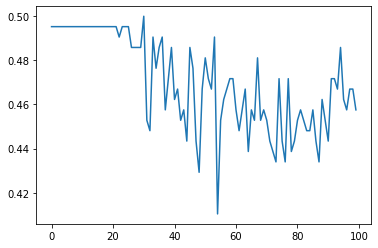

In [354]:
history = model.fit(X_train,y_train,validation_data = (X_test, y_test),epochs = 100, shuffle = True, verbose = 0)
if cum_history is None:
    cum_history = history.history
else:
    cum_history = merge_model_histories(cum_history,history.history)
plt.plot(cum_history["val_accuracy"])
max_val_acc = np.round(max(cum_history["val_accuracy"]),3)
print(f"Window: {window}, model: {model.name}, max_val_accuracy:{max_val_acc}")

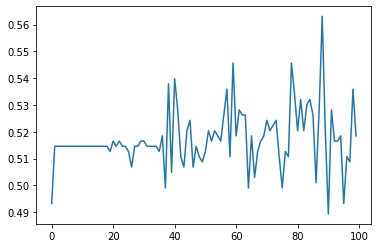

In [310]:
plt.plot(cum_history["accuracy"])

In [162]:
a  = [2017,1969,1946,1903]
for i in range(4):
    print(a[i] - a[i+1])

48
23
43


IndexError: list index out of range

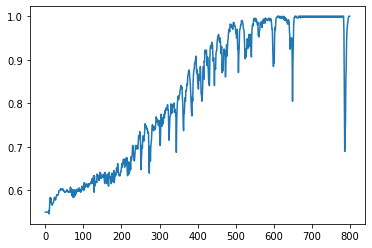

In [161]:
plt.plot(cum_history["accuracy"])

In [357]:
predictions = model.predict(X_test)

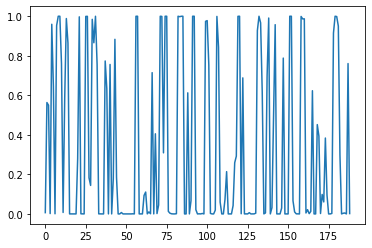

In [360]:
plt.plot(predictions.flatten())

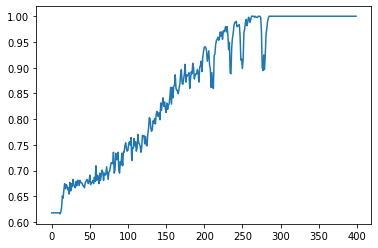

In [354]:
plt.plot(history.history["accuracy"])

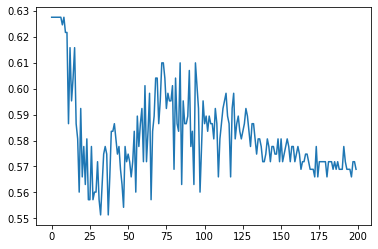

In [323]:
#window = 25, onehot, 61%, lstm_clf 
plt.plot(history.history["val_accuracy"])
#plt.plot(history.history["accuracy"])

In [163]:
from pipeline import Pipeline
from utils_time_series import *

In [167]:
p = Pipeline(hello)

In [148]:
p.add_moving_averages(7,10, 20)

In [165]:
standardize = True
returns = True
threshold = '2020-01-01'
window = 20
epochs = 100

In [168]:
p.create_rolling_windows_and_target(window)

# create train and test datasets
p.split_by_date(threshold)
n_features = p.X.shape[-1]

In [173]:
p.X.shape

(711, 20, 15)

In [169]:
#define and train model
p.model = lstm_clf(window,n_features)
p.fit_model(epochs=epochs)
p.make_predictions()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 50)            13200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 20)            1020      
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 401       
Total params: 14,621
Trainable params: 14,621
Non-trainable params: 0
_________________________________________________________________
None


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

Epoch 1/150
9/9 [==============================] - 6s 165ms/step - loss: 0.1434 - val_loss: 1.6442
Epoch 2/150
9/9 [==============================] - 0s 27ms/step - loss: 0.1160 - val_loss: 1.6457
Epoch 3/150
9/9 [==============================] - 0s 29ms/step - loss: 0.1098 - val_loss: 1.6452
Epoch 4/150
9/9 [==============================] - 0s 22ms/step - loss: 0.1288 - val_loss: 1.6455
Epoch 5/150
9/9 [==============================] - 0s 21ms/step - loss: 0.1069 - val_loss: 1.6490
Epoch 6/150
9/9 [==============================] - 0s 20ms/step - loss: 0.1227 - val_loss: 1.6477
Epoch 7/150
9/9 [==============================] - 0s 20ms/step - loss: 0.1338 - val_loss: 1.6489
Epoch 8/150
9/9 [==============================] - 0s 20ms/step - loss: 0.1242 - val_loss: 1.6486
Epoch 9/150
9/9 [==============================] - 0s 20ms/step - loss: 0.1015 - val_loss: 1.6429
Epoch 10/150
9/9 [==============================] - 0s 21ms/step - loss: 0.1014 - val_loss: 1.6431
Epoch 11/150
9/9 [

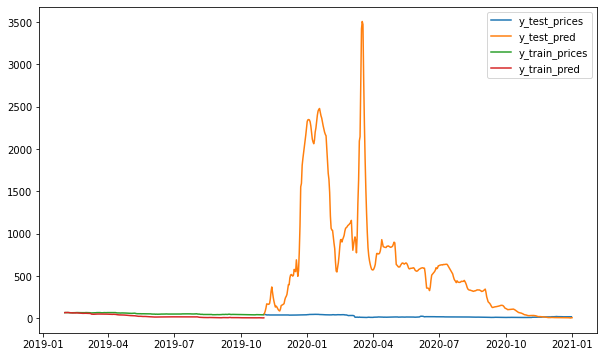

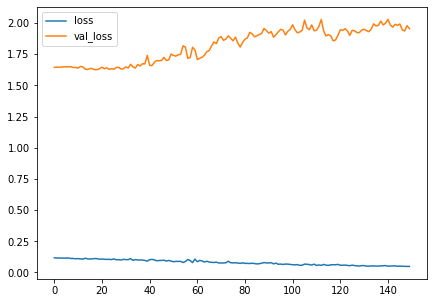

In [178]:
p.dropna()
if returns:
    p.prices_to_returns()
if standardize:
    p.standarize()
p.create_rolling_windows_and_target(window)

# create train and test datasets
p.split_by_date(threshold)
n_features = p.X.shape[-1]

#define and train model
p.model = lstm_model(window,n_features)
p.fit_model(epochs=epochs)
p.make_predictions()
if standardize:
    p.destandarize_predictions()
if returns:
    p.returns_to_prices_predictions()
p.plots()

In [152]:
from utils_time_series import *

In [153]:
d = df.copy()

In [154]:
prices = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [155]:
d[prices] = d[prices].pct_change(1).fillna(0)

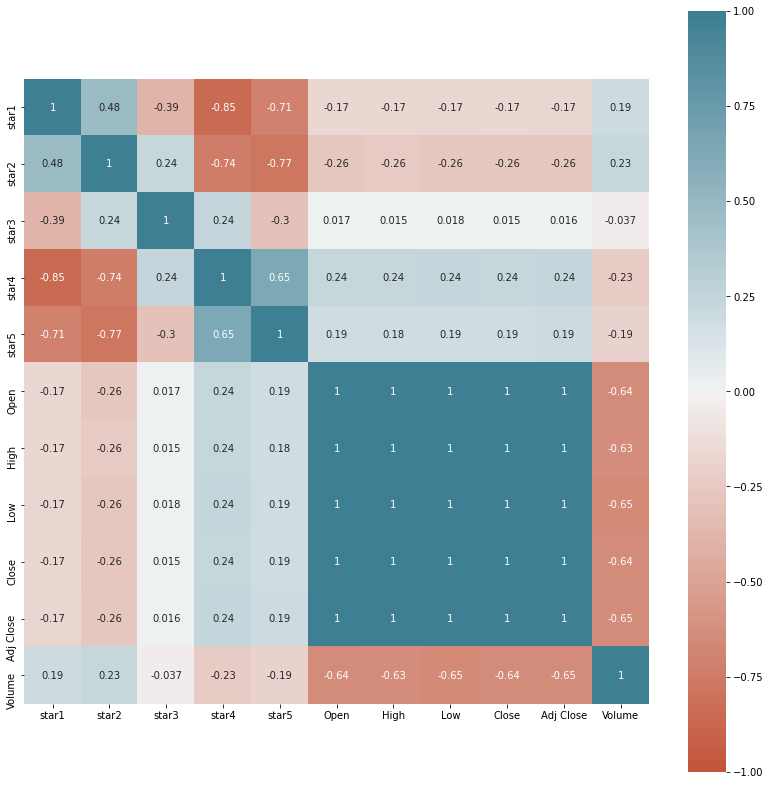

In [158]:
fig, ax = plt.subplots(figsize=(14,14))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)

<AxesSubplot:>

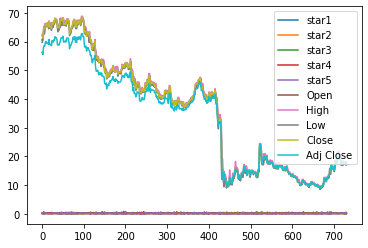

In [157]:
sentiment[stock].drop(columns = ["date", "Volume"]).plot()

<AxesSubplot:xlabel='date', ylabel='star5'>

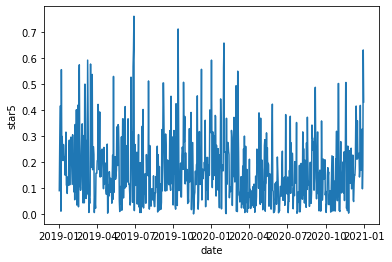

In [81]:
sns.lineplot(y = sentiment[stock]["star5"], x = sentiment[stock]["date"] )

In [67]:

stock_names = []
start = "2019-01-03"
end   = "2020-03-19"
threshold = "2019-11-01"
window = 10
epochs = 150 #250

# Download series